In [24]:
from time import perf_counter_ns
from subprocess import Popen, PIPE , STDOUT
import multiprocessing
from math import inf
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import requests as re

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#bin = "./samples/vulnO0"          #ścieżka do programu, który będzie testowany 
#bin ="./samples/keygen"         #https://crackmes.one/crackme/6403ac2a33c5d447bc76179f
#bin ="./samples/virtual.1"    #https://crackmes.one/crackme/5f3a64df33c5d42a7c667d45 prefix username
bin="./samples/hangover"      #PINGCTF :) flag size 34
#bin = "./samples/vulnO0"
MAX_STRING_SIZE = 32    #Maksymalna długość wejściowego ciągu znaków który jest sprawdzany
BATCH_SIZE = 2        #Ilość powtórzeń dla każdego każdego wejścia (pozwala na zminimalizowanie "szumów")
THREADS = 4          #Ilość wątków, które będą równolegle testować program (uwaga, zbyt duża ilość wątków może wprowadzić niechciane szumy)
avg_or_min = 0          #spsób zliczania czasu, 0 - średnia, 1 - minimalny
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789-!@#$%^&*{{}}_" #alfabet znaków, które będą sprawdzane
use_args = False        #czy używać argumentów w programie
prefix = ""             #prefix który będzie dodawany do każdego wejścia
suffix = ""           #sufix który będzie dodawany do każdego wejścia
use_server = False      #czy używać serwera do testowania
password_file = 'passwords.txt'
url = 'http://localhost:5000/auth'
url = 'http://192.168.1.103:5000/auth'
known_username = 'antoninaantonino'

Funkcja zliczająca ilość instrukcji procesora wykonancyh przez program. Pod spodem używane jest narzędzie `callgrind` z pakietu `valgrind` do zliczenia instrukcji. Alternatywnie można użyć `perf`. Warto zaznaczyć że oba narzędzia są dostępne tylko na linuxie.

In [25]:

def test_for_input(inp: str, num,remote=False):
    inp = prefix + inp + suffix
    sum = 0
    min = inf
    for i in range(num):
        if not remote:
            if not use_args:
                cmd = f"echo \'{inp}\' | valgrind --tool=callgrind    --callgrind-out-file=cg.out {bin}" #komenda do uruchomienia programu z valgrindem
            else:
                cmd = f"valgrind --tool=callgrind    --callgrind-out-file=cg.out {bin} \'{inp}\'"
            p = Popen(cmd, shell=True, stdout=PIPE, stderr=STDOUT)
            p.wait()
            out = p.communicate()
            ins = 0

            for line in out:
                if line is None:
                    continue
                for line2 in line.decode().split("\n"):
                    if "Collected" in line2:
                        ins = int(line2.split()[3])
                        break
        else:
            data = {'username': known_username, 'password': inp}
            r = re.post(url, data=data)
            ins = r.elapsed.microseconds
        sum += ins
        if ins < min:
            min = ins
    ins = sum / num
    return (ins,min) #zwracamy średnią i minimalną ilość instrukcji

Ta część kodu odpowiada za znajdywanie odpowiedniej długości hasła.

Probable length: 0


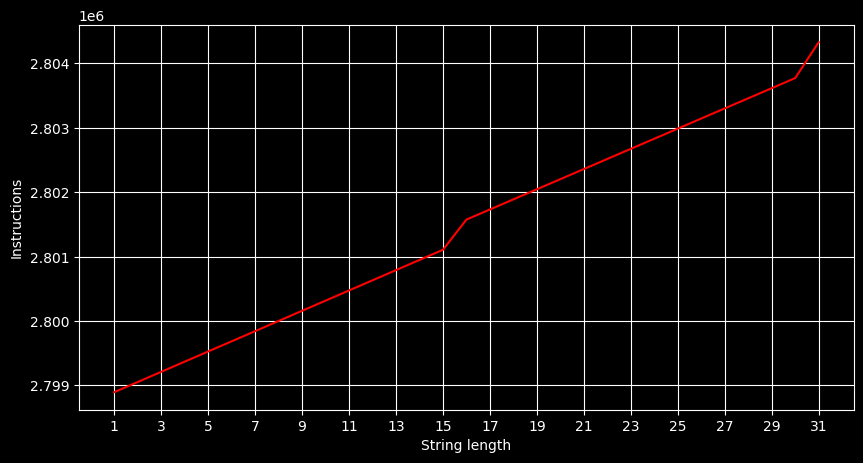

In [26]:


char_time = {}
pool = multiprocessing.Pool(processes=THREADS)

inputs = []
for i in range(1, MAX_STRING_SIZE):
    inputs.append("A" * i) #tworzymy wejścia, które będą testowane

results = pool.starmap(test_for_input, [(inp, BATCH_SIZE,use_server) for inp in inputs]) #testujemy program dla każdego wejścia
maxtime = 0

probable_len = 0
for i in range(len(results)):
    if i >0 and i < len(results) - 1:
        if results[i-1][avg_or_min] < results[i][avg_or_min] and results[i][avg_or_min] > results[i+1][avg_or_min]:
            probable_len = i+1 #szukamy nagłego wzrostu czasu dla jednego wejścia i potem nagłego spadku

print(f"Probable length: {probable_len}")
plt.grid()
plt.xlabel('String length')
plt.ylabel('Instructions')
plt.gcf().set_size_inches(10, 5)
plt.xticks(range(1, MAX_STRING_SIZE,2))
plt.style.use('dark_background')    #kolory KN ping
plt.plot(range(1, MAX_STRING_SIZE), [x[avg_or_min] for x in results],color='red')
plt.show()


Na wykresie możemy zaobserwoać wzrost czasu przy długości 12 i znowu spadek dla 13 co może sugerować długość hasła. Wzrost czasu przy długości 16 najprawdopodobniej wywołany jest implementacją `String` w C++ która prawdopodobnie alokuje dodatkową pamięć przy przekroczeniu rozmaru potęgi liczby 2.

Znając przypuszczaną długość hasła możemy przejść do prób odgadnięcia hasła poprzez sprawdzanie każdego znaku po kolei i sprawdzanie, dla którego program wykonał najwięcej instrukcji.

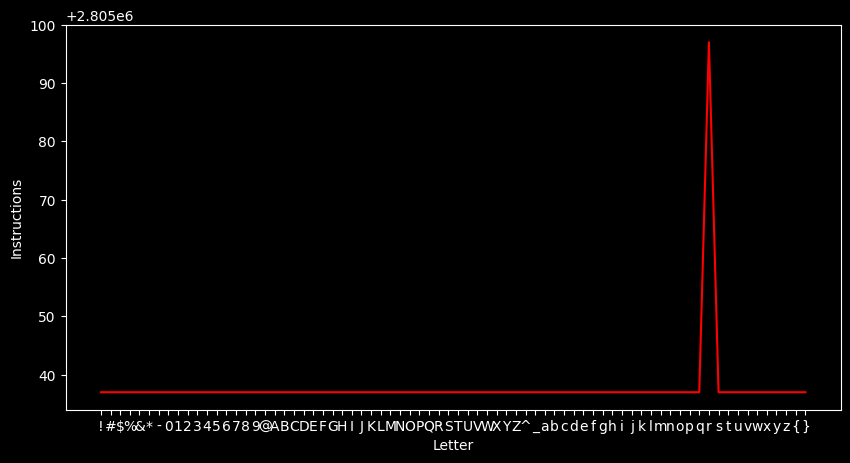

ping{r
Time: 2805097.0
{'A': 2805037.0, 'B': 2805037.0, 'C': 2805037.0, 'D': 2805037.0, 'E': 2805037.0, 'F': 2805037.0, 'G': 2805037.0, 'H': 2805037.0, 'I': 2805037.0, 'J': 2805037.0, 'K': 2805037.0, 'L': 2805037.0, 'M': 2805037.0, 'N': 2805037.0, 'O': 2805037.0, 'P': 2805037.0, 'Q': 2805037.0, 'R': 2805037.0, 'S': 2805037.0, 'T': 2805037.0, 'U': 2805037.0, 'V': 2805037.0, 'W': 2805037.0, 'X': 2805037.0, 'Y': 2805037.0, 'Z': 2805037.0, 'a': 2805037.0, 'b': 2805037.0, 'c': 2805037.0, 'd': 2805037.0, 'e': 2805037.0, 'f': 2805037.0, 'g': 2805037.0, 'h': 2805037.0, 'i': 2805037.0, 'j': 2805037.0, 'k': 2805037.0, 'l': 2805037.0, 'm': 2805037.0, 'n': 2805037.0, 'o': 2805037.0, 'p': 2805037.0, 'q': 2805037.0, 'r': 2805097.0, 's': 2805037.0, 't': 2805037.0, 'u': 2805037.0, 'v': 2805037.0, 'w': 2805037.0, 'x': 2805037.0, 'y': 2805037.0, 'z': 2805037.0, '0': 2805037.0, '1': 2805037.0, '2': 2805037.0, '3': 2805037.0, '4': 2805037.0, '5': 2805037.0, '6': 2805037.0, '7': 2805037.0, '8': 2805037.0, 

KeyboardInterrupt: 

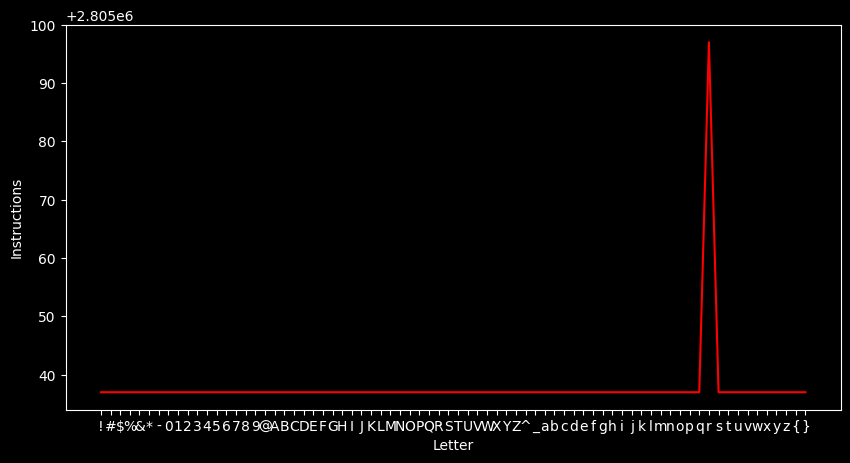

In [27]:

length = probable_len
length = 34
known = ""
plt.ion()
plt.show()
for i in range(length):
    char_time = {}  #słownik z czasami dla każdego znaku
    inputs = []     #lista wejść, które będą testowane
    for char in alphabet:
        inputs.append(known + char + "A" * (length - i - 1)) 
    results = pool.starmap(test_for_input, [(inp, BATCH_SIZE,use_server) for inp in inputs]) #rozdajemy zadania do wątków
    for i in range(len(results)):
        char_time[inputs[i][len(known)]] = results[i][avg_or_min] 
        
    maxtime = 0
    maxchar = ""
    for char in char_time: #szukamy znaku, który ma największy czas
        if char_time[char] > maxtime:
            maxtime = char_time[char]
            maxchar = char
    known += maxchar #dodajemy znak do hasła
    plt.clf()
    plt.xlabel('Letter')
    plt.ylabel('Instructions')
    plt.style.use('dark_background')    #kolory KN ping
    xticks = list(char_time.keys())
    xticks.sort()
    plt.xticks(range(len(xticks)), xticks)
    plt.plot(range(len(xticks)), [char_time[x] for x in xticks],color='red')
    plt.gcf().set_size_inches(10, 5)
    #live update
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
    else:
        plt.pause(0.001)
    print(known)
    print(f"Time: {maxtime}")
    print( char_time)

print(f"Password: {known}")
plt.ioff()
    



